<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Global Ensemble Shapley Values

#### Abraham Montes
##### [LinkedIn](https://www.linkedin.com/in/abraham-montes-humanez-6661a841/) | [GitHub](https://github.com/acmontesh) | [GoogleScholar](https://scholar.google.com/citations?user=Va0vQdsAAAAJ&hl=es)
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

Feature selection is necessary in a great proportion of real life machine learning applications, drilling among them. One approach to such problem is achieved with Shapley values (adapted from game theory, to calculate marginal contributions of each feature in the predictions), but it has a big flaw: It requires to assume a model. Wolpert posed in 1996 the No-Free lunch set of theorems, where is stated that there is no reason to select one model over any other one before experimentation is carried out. This means that doing feature selection with only one model would lead to an incorrect estimation of feature importance (e.g., from a highly biased model) or worse: A loss of important information, if deletion follows the ranking. 

To tackle this problem, we propose an ensemble of models instead of only one to calculate the Global Shapley values. As we will see at the end of this workflow, the feature ranking resulting from the ensemble differs from the individual rankings extensively. 

The recommendation from this result, is to use ensemble global Shapley values instead of committing to a model when ranking the features that will be used to perform inference, specially if dimensionality reduction from feature deletion follows the feature ranking, with this, the risk of having an incorrect ranking, or even loss of important information is reduced significantly, as there is no need to make a strong assumption about the model before actually building it. 


### Import Packages



In [170]:
import numpy as np                  #For arrays manipulation
import shap                         #For shapley values calculation
import matplotlib.pyplot as plt     #For plotting
import seaborn as sb                #This is a matplotlib wrapper that enables nice-looking plots with lesser code.
import pandas as pd                 #For rectangular data manipulation in Dataframes
import sklearn as skl


### Functions


In [169]:
#Code from Source code of SHAP library / Summary Plot

def shapley_feature_ranking(shap_values, X):
    feature_order = np.argsort(np.mean(np.abs(shap_values), axis=0))
    return pd.DataFrame(
        {
            "features": [X.columns[i] for i in feature_order][::-1],
            "importance": [
                np.mean(np.abs(shap_values), axis=0)[i] for i in feature_order
            ][::-1],
        }
    )

Source code for SHAP library available [here](https://github.com/slundberg/shap)

### Load Data

The following workflow applies the .csv file 'Well_5832_data.csv', an exerpt of a real dataset containing the average of sensors reading per foot of hole drilled in geothermal wells in the state of Utah. The exerpt is available [here](https://raw.githubusercontent.com/acmontesh/SSML/main/Well_5832_data.csv). The complete dataset is publically available [here](https://gdr.openei.org/submissions/1113) $^{[1]}$

We will work with the following features:

* **depth** - Well depth in feet [ft]
* **rop** - Rate of penetration in feet per hour [ft/h]
* **wob** - Weight on bit in kilopounds [klb]
* **temp_out** - Mud temperature at the shaker's distribution box in Farenheit degrees [degF]
* **rpm** - Surface induced rotation speed in revolutions per minute [rev/min]
* **gpm** - Mud flow rate going in the drillstring in gallons per minute [gal/min]


----------------
$^{[1]}$ Podgorney, Robert, McLennan, John, & Moore, Joe. Utah FORGE: Drilling Data for Student Competition. United States. https://dx.doi.org/10.15121/1495411

In [3]:
# load the comma delimited data file from Abraham Montes' GitHub repository
my_data = pd.read_csv(r"https://raw.githubusercontent.com/acmontesh/SSML/main/Well_5832_data.csv") 

### Global Ensemble Shapley Values

In this workflow, we will explore the ensemble approach for solving the feature selection problem by using shapley values. Next, a brief summary of the steps:

1. Data Exploration and Preprocessing

2. Creation and Training of the Ensemble

3. Marginal Contributions Calculation

4. Summary of Ensemble Global Shapley Values



### 1. Data Exploration and Preprocessing

In this step, we evaluate the dataset with descriptive statistics and visualize the features univariate and bivariate distributions, in order to identify possible correlation between features (i.e., variable dependence), outliers, cappings, and other issues that need to be taken care of before proceeding with models' training.

It is important to note that this step is of vital importance before any Shapley value is calculated. The reason is simple: Shapley values are model dependent, and thus, carry all the models' limitations and assumptions with them. 

In [4]:
my_data.describe() #Allows us to see summary statistics of the dataset

,depth,rop,wob,temp_out,rpm,gpm
count,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000
mean,3835.043935,42.010324,23.116699,126.059506,54.947292,716.254127
std,2147.503980,75.921118,9.119495,12.259879,25.947654,141.784179
min,85.180000,0.000000,0.000000,84.070000,0.000000,0.000000
25%,1970.395000,11.400000,18.310000,116.130000,38.090000,620.260000
50%,3851.850000,17.990000,23.830000,124.860000,50.380000,700.210000
75%,5691.585000,44.295000,29.680000,136.490000,75.965000,824.610000
max,7536.250000,2977.910000,47.050000,151.700000,271.580000,3317.510000


Judging by the difference between the 3rd quartile and the maximum in ROP, GPM and RPM, it appears the dataset includes a long tail (i.e., what James et al. call high levereage points). Since the density is low compared to low values and therefore, there may be lack of coverage, they may be considered as outliers and treated with likewise deletion. Note that low ROP values are of interest in drilling engineering, since the most common purpose of building ROP predictors is to optimize the parameters combination at each depth that would lead to the best ROP. 

Let us confirm this suspected issue by visually inspecting the dataset:

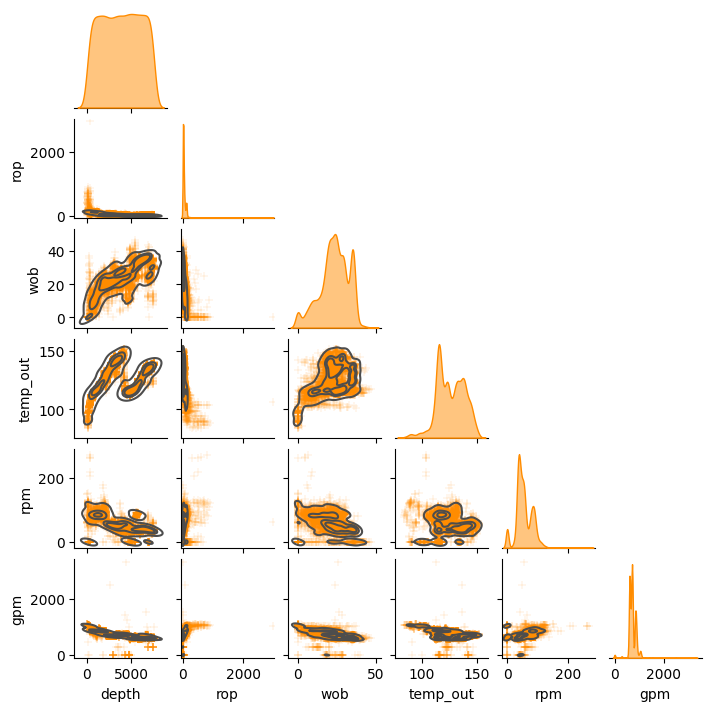

In [7]:
#Generates the sparse matrix: Univariate distributions in the main diagonal and pairwise bivariate distributions below.
g=sb.pairplot(
    my_data,diag_kind = "kde", 
    plot_kws=dict(marker="+", linewidth=0.1, c='darkorange'),
    diag_kws=dict(color='darkorange',alpha=0.5), height=1.2, corner=True,
)

#Calculates and plots the continuous probability density curve for each of the bivariate distributions.
g.map_lower(sb.kdeplot, levels=4, color=".3");

Finally, before recapping the first exploration, let us  zoom into the univariate distributions:

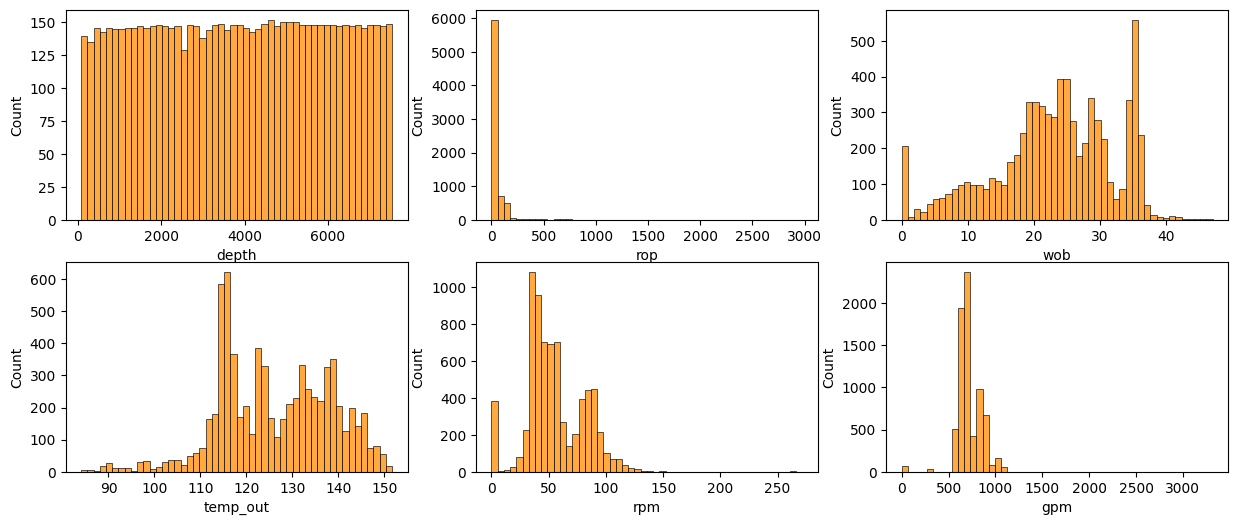

In [8]:
fig,axs=plt.subplots(2,3,figsize=(15,6))
for i,col in enumerate(my_data.columns):
    sb.histplot(data=my_data, bins=50, x=col, log_scale=False, color='darkorange', ax=axs[i//3,i%3]);

Some observations from the univariate distributions and the sparse matrix: 
<ul>
<li>ROP (the response) has a heavy tail that drags the expectation far away from the median. In drilling, this may be the result of 2 conditions: 1) Decallibration of the ROP due to missing zeroing of the WOB, and 2) True abnormaly soft intervals that can be drilled even without applying WOB. Since the number of samples is low for the abnormaly high values of the response (lack of coverage), we can experiment the likewise deletion of these instances</li> <br>
<li>The flow rate (GPM) also shows a very thin righ tail. This is 100% caused by wrong readings from the SPM sensor. The pumps capacity is way below 2000 gpm. We will clean these outliers out, placing the cuttoff at 1500 gpm, from the pumps capacity</li> <br>

<li>
The rotation speed (rpm) has the same situation as Flow rate. We will cap this variable at 160 rpm, which is above a common continuous RPM cap for 800HP top drives for drilling (or tripping) torque less than 27 klb-ft.
</li><br>

<li>We are also not interested in depths shallower than 300 ft, because this typically corresponds to cleaning of conductor pipe , instad of drilling consolidated rock</li><br>

<li>Finally, what we see in the bivariate between temperature out and depth is very interesting. It reflects the fact that we are dealing with 2 different sections. Once the casing is lowered and cemented, a large amount of friction is faded out</li><br>
</ul>

----------------
$^{[3]}$ NOV. TDS 11-SA: The World Most Popular Top Drive. Available at [NOV TDS11SA Brochure](https://www.nov.com/-/media/nov/files/products/rig/rig-equipment/top-drive-systems/tds-11sa-top-drive-flyer.pdf)

Let us take care of the aforementioned tasks.

In [20]:
my_data_pp = my_data.copy(deep=True)    #Creates a deep copy of the dataframe.
#Filters the dataset with the aforementioned criteria. 
my_data_pp=my_data_pp[(my_data_pp['gpm']<1500) & (my_data_pp['rpm']<160) & (my_data_pp['rop']<150) & (my_data_pp['depth']>300)]
my_data_pp.describe() #Calculates summary statistics of the modified dataset.

,depth,rop,wob,temp_out,rpm,gpm
count,7033.000000,7033.000000,7033.000000,7033.000000,7033.000000,7033.000000
mean,3974.144792,32.749892,23.883488,127.145508,54.812338,704.246047
std,2067.553535,33.617378,8.311849,11.072084,23.859416,124.328868
min,300.580000,0.000000,0.000000,101.300000,0.000000,0.000000
25%,2178.440000,11.190000,18.980000,116.510000,38.270000,619.170000
50%,3989.540000,17.260000,24.150000,125.970000,50.260000,698.170000
75%,5761.040000,40.340000,29.900000,136.850000,75.000000,739.660000
max,7536.250000,149.760000,47.050000,151.700000,146.030000,1417.550000


We can compare the amount of data deleted. We see the percentage of deleted instances is reasonable and should not introduce a significant bias. 

In [22]:
print("The number of instances deleted was: %4d, which is the %4.2f%% of the original number of instances"%(my_data.shape[0]-my_data_pp.shape[0],(my_data.shape[0]-my_data_pp.shape[0])*100/my_data.shape[0]))

The number of instances deleted was:  278, which is the 3.80% of the original number of instances


To check the validity of this statement, let us re visualize the distributions:

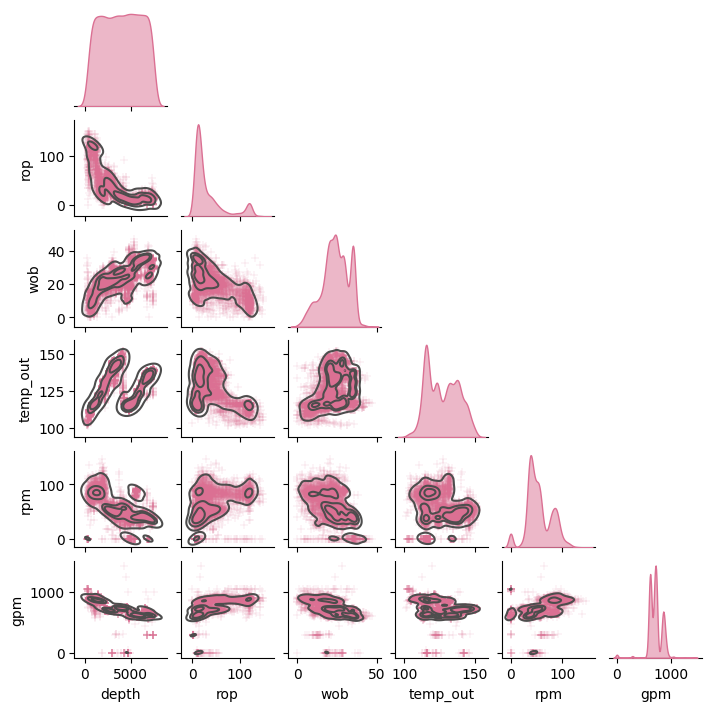

In [23]:
#Generates the sparse matrix and the KDE approximation as previously done, with the modified dataset.
g=sb.pairplot(
    my_data_pp,diag_kind = "kde", 
    plot_kws=dict(marker="+", linewidth=0.1, c='palevioletred'),
    diag_kws=dict(color='palevioletred', alpha=0.5), height=1.2, corner=True,
)

g.map_lower(sb.kdeplot, levels=4, color=".3");

This is much better than the initial dataset, since distributions are no longer heavy tailed and outliers appear to have been "pruned". Let's finally standardize the features (not the response), in order to ensure distance-based models are not influenced by differences in scales. 

In [24]:
#Feature Standardization
from sklearn.preprocessing import StandardScaler

my_data_std = my_data_pp.copy(deep=True)    #Creates a deep copy of the dataset
scaler = StandardScaler()                   #Instantiates the class StandardScaler
cols = my_data_std.columns                  #Saves the list of column names into "cols"
my_data_std=scaler.fit_transform(my_data_std.values)    #Forces the features on mean 0 and standard deviation 1.
my_data_std = pd.DataFrame(my_data_std, columns=cols)   #Reformats the numpy array that contains the standardized dataset into a data frame.
my_data_std.describe()  #Summary statistics of the standardized dataset

,depth,rop,wob,temp_out,rpm,gpm
count,7.033000e+03,7033.000000,7.033000e+03,7.033000e+03,7033.000000,7033.000000
mean,1.293182e-16,0.000000,-1.939773e-16,5.980965e-16,0.000000,0.000000
std,1.000071e+00,1.000071,1.000071e+00,1.000071e+00,1.000071,1.000071
min,-1.776895e+00,-0.974265,-2.873631e+00,-2.334461e+00,-2.297468,-5.664783
25%,-8.685785e-01,-0.641377,-5.899814e-01,-9.606380e-01,-0.693375,-0.684331
50%,7.446628e-03,-0.460803,3.206640e-02,-1.061762e-01,-0.190812,-0.048874
75%,8.643173e-01,0.225795,7.238991e-01,8.765452e-01,0.846169,0.284861
max,1.722982e+00,3.480891,2.787365e+00,2.217852e+00,3.823402,5.737643


Now, let's separate the predictor features and the response variable:

In [124]:
X = my_data_std.drop(['rop'],axis=1).values     #Removes the ROP column and transforms to numpy array
y = my_data_std['rop'].values     #Extracts the ROP column and converts to numpy array, reshaped properly.

### 2. Creation and Training of the Ensemble

Now, with a preprocessed dataset, we proceed in this step to create a list of models and fit them to the data. In this project, we select 15 different models to carry out the experiment. Nonetheless, it is possible to extend the ensemble to any number of models.



##### 2.1. Model #1-3 - Neural Networks

In [125]:
from sklearn.neural_network import MLPRegressor

#Model 1 with 5 hidden neurons and ReLU activation
model1=skl.neural_network.MLPRegressor(hidden_layer_sizes=(5), activation='relu', solver='adam')

#Model 1 with 5 hidden neurons and Hyperbolic tan activation
model2=skl.neural_network.MLPRegressor(hidden_layer_sizes=(5), activation='tanh', solver='adam')

#Model 1 with 2 hidden layers and 5 hidden neurons in each, with ReLU activation
model3=skl.neural_network.MLPRegressor(hidden_layer_sizes=(5,5), activation='relu', solver='adam')


r   =  model1.fit(X, y)         #Trains the model 1.
r   =  model2.fit(X, y)
r   =  model3.fit(X, y)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


##### 2.2. Model #4-7 - Support Vector Machines

In [45]:
model4 = skl.svm.SVR(kernel="linear", C=1.0, epsilon=0.2)                   #Creates an SVM with linear kernel
model5 = skl.svm.SVR(kernel="rbf", C=1.0, epsilon=0.2)                      #Creates an SVM with Radial-Gaussian kernel
model6 = skl.svm.SVR(kernel="poly", degree=2, C=1.0, epsilon=0.2)           #Creates an SVM with Polynomial kernel degree 2       
model7 = skl.svm.SVR(kernel="poly", degree=3, C=1.0, epsilon=0.2)           #Creates an SVM with Polynomial kernel degree 3
models = [model4, model5, model6, model7]                                    #Creates a list of the models above
for model in models:                                                        #Fits every model in the list
    model.fit(X,y.reshape(-1,))

##### 2.3. Model #8-10 - Linear Regression, Ridge and KNN

In [140]:
model8 = skl.linear_model.LinearRegression()
model9 = skl.linear_model.Ridge()
model10 = skl.neighbors.KNeighborsRegressor(weights='distance', n_neighbors=10)

models = [model8, model9, model10]                                    
for model in models:                                                                
    model.fit(X,y.reshape(-1,))

##### 2.4. Model #11-15 - Decision Trees and Random Forest

In [47]:
model11 = skl.tree.DecisionTreeRegressor(max_leaf_nodes=10)
model12 = skl.tree.DecisionTreeRegressor(max_leaf_nodes=30)
model13 = skl.tree.DecisionTreeRegressor(max_leaf_nodes=50)
model14 = skl.ensemble.RandomForestRegressor(n_estimators=100)
model15 = skl.ensemble.RandomForestRegressor(n_estimators=500)

models = [model11, model12, model13, model14, model15]                                    
for model in models:                                                                
    model.fit(X,y.reshape(-1,))

### 3. Marginal Contributions Calculations

We now have a set of trained models. We proceed to calculate the global shapley values for each of the models and each of the features.
Recall that the Global Shapley values are calculated as:

$$
G_j = \frac{1}{|M|}\sum_{i\in M}|s_i|
$$

Where $M$ is the number of predictions and the local Shapley values $s_i$ are $^{[2]}$:

$$
s_i = \sum_{S \subseteq N \setminus i} \frac{|S|! (|N|-|S|-1)!}{N!} \left[ v(S\cup i) - v(S) \right]
$$

<br>

Where $v$ is each model in the ensemble; $N$ is the set of features; $i$ is each feature in $N$ and $S$ is a subset of $N$, containing a fraction or all the features in $N$, except the feature $i$.

----------------
$^{[2]}$ Sundararajan, M. and Najmi, A. *The Many Shapley Values for Model Explanation.* Proceedings of the 37 th International Conference on Machine Learning, Online, PMLR 119, 2020.

Before calculating the Shapley values, we extract a random portion of the dataset. This is due to the fact that shapley values are computationally challenging, since the calculation involves calculating over the combinations of possible features once each one is removed from the set of 5 festures. 

In [128]:
X_subset = shap.sample(X, 200)  #Extracts a subset sample of 500 instances. 

Let's now proceed to calculate Global Shapley values with the trained models.

In [142]:
models = {'NeuralNet 1 hidden layer 5 hidden neurons ReLU':model1,
          'NeuralNet 1 hidden layer 5 hidden neurons tanh':model2,
          'NeuralNet 2 hidden layer 5 hidden neurons ReLU':model3,
          'SVM with Linear Kernel':model4,
          'SVM with Radial Kernel':model5,
          'SVM with Polynomial Kernel of Degree 2':model6,
          'SVM with Polynomial Kernel of Degree 3':model7,
          'Linear Regression':model8,
          'Ridge Regression':model9,
          'K-Nearest Neighbor Regression':model10,
          'Decision Tree Regressor with 10 max terminal nodes':model11,
          'Decision Tree Regressor with 30 max terminal nodes':model12,
          'Decision Tree Regressor with 50 max terminal nodes':model13,
          'Random Forest Regressor with 100 trees':model14,
          'Random Forest Regressor with 500 trees':model15}

In [130]:
feature_names=list(my_data.columns) #This extracts the feature names from the original dataset
feature_names.remove('rop')         #Removes the ROP, which is the response feature.
feature_names

['depth', 'wob', 'temp_out', 'rpm', 'gpm']

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:31<00:00,  6.42it/s]


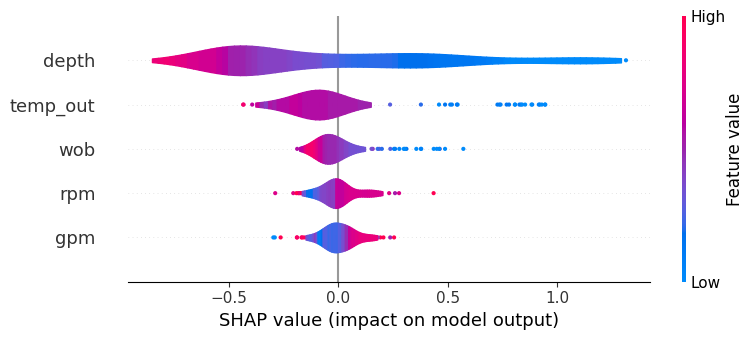

In [141]:
ex = shap.KernelExplainer(model10.predict, X_subset)
shap_values = ex.shap_values(X_subset)
shap.summary_plot(shap_values, X_subset, feature_names=feature_names, plot_type = "violin")


The following for loop iterates over the list of trained models and calculates global Shapley values. Finally, this line: 
```python
shapley_feature_ranking(shap_values, pd.DataFrame(X_subset, columns=feature_names))
```
creates a DataFrame with the feature importance index calculated on the Global shapley values for the $i$-th model. Finally, the code: 

```python
for index,row in shapley_feature_ranking(shap_values, pd.DataFrame(X_subset, columns=feature_names)).iterrows():
        importances[row['features']] += row['importance'] 
```

adds the importances on each feature on the dictionary of importances. 

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:08<00:00, 24.03it/s]


NeuralNet 1 hidden layer 5 hidden neurons ReLU


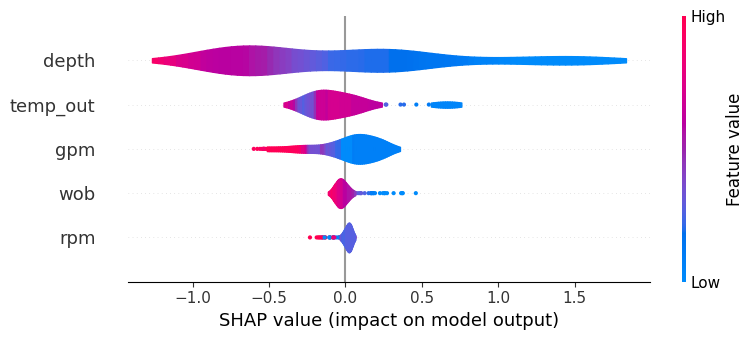

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:08<00:00, 23.76it/s]


NeuralNet 1 hidden layer 5 hidden neurons tanh


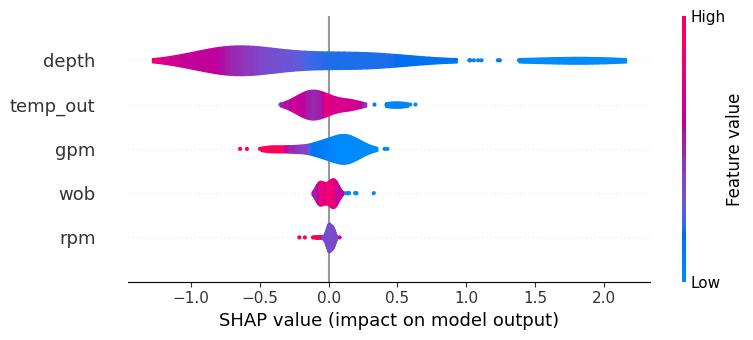

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:08<00:00, 23.66it/s]


NeuralNet 2 hidden layer 5 hidden neurons ReLU


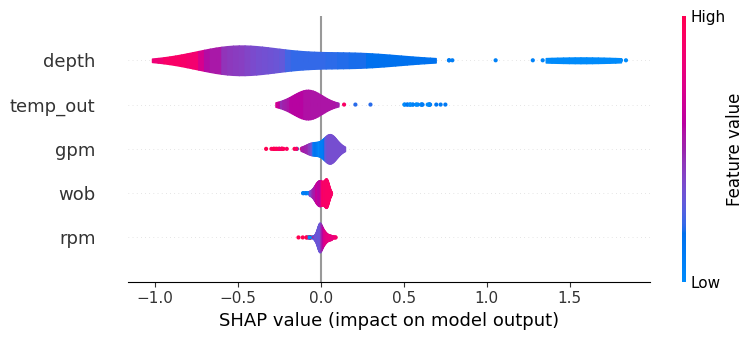

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [01:35<00:00,  2.09it/s]


SVM with Linear Kernel


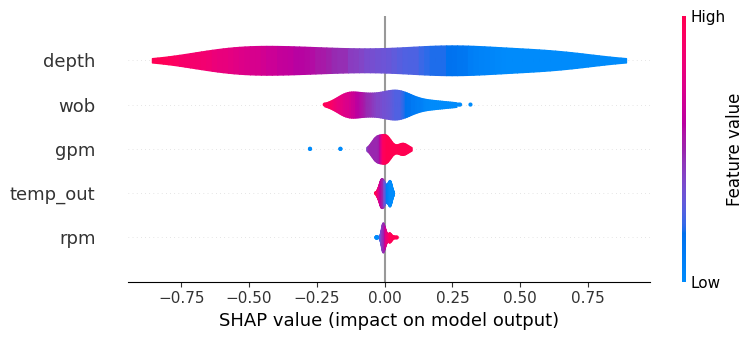

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


SVM with Radial Kernel


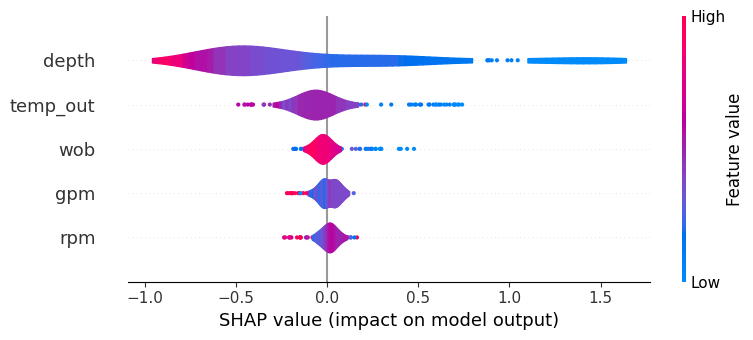

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [01:26<00:00,  2.30it/s]


SVM with Polynomial Kernel of Degree 2


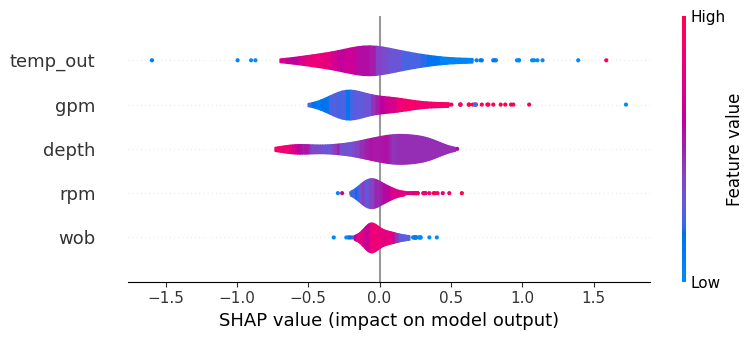

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


SVM with Polynomial Kernel of Degree 3


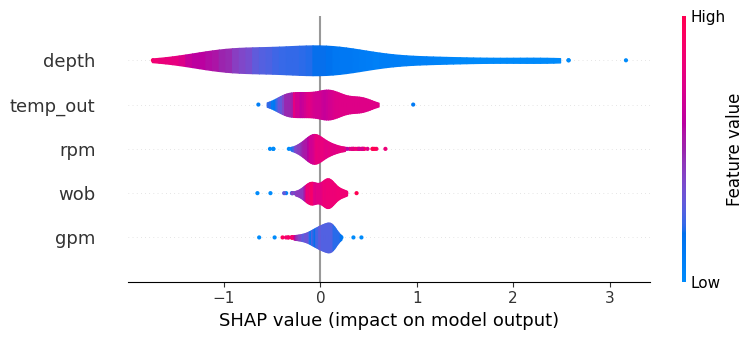

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:09<00:00, 22.05it/s]


Linear Regression


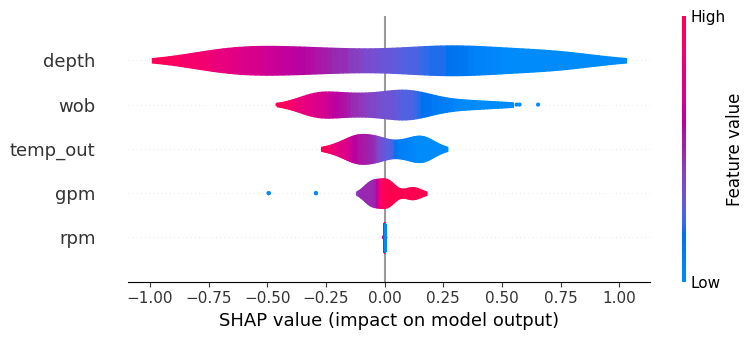

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:08<00:00, 24.44it/s]


Ridge Regression


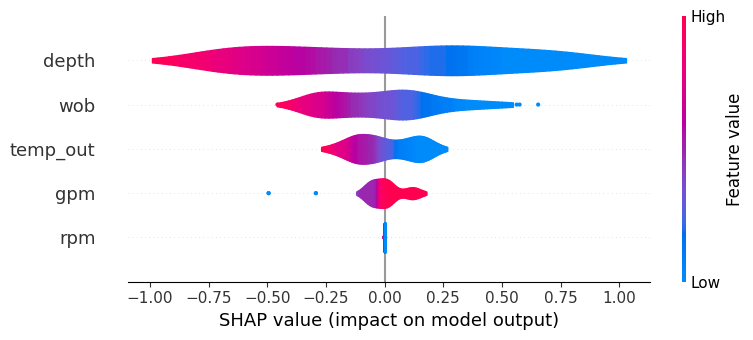

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


K-Nearest Neighbor Regression


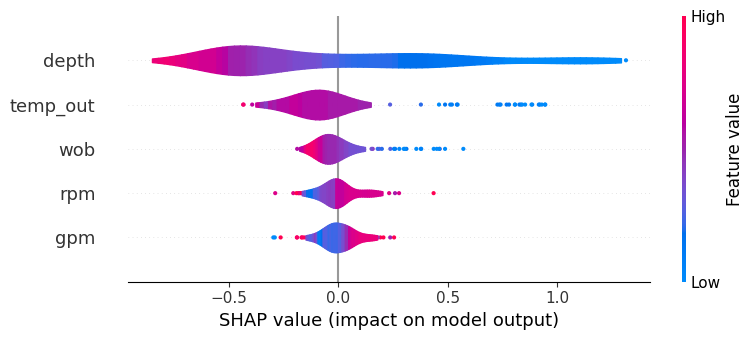

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:08<00:00, 24.15it/s]


Decision Tree Regressor with 10 max terminal nodes


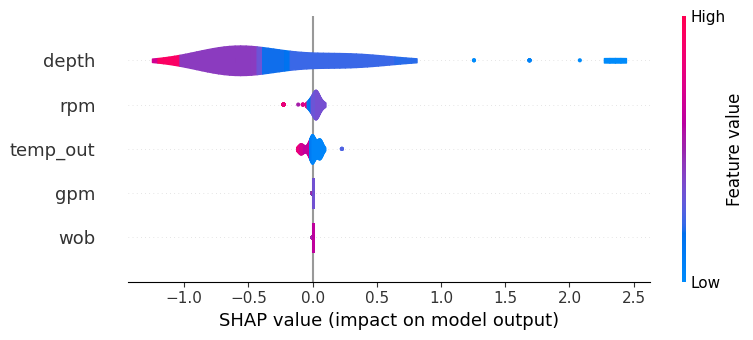

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:08<00:00, 24.47it/s]


Decision Tree Regressor with 30 max terminal nodes


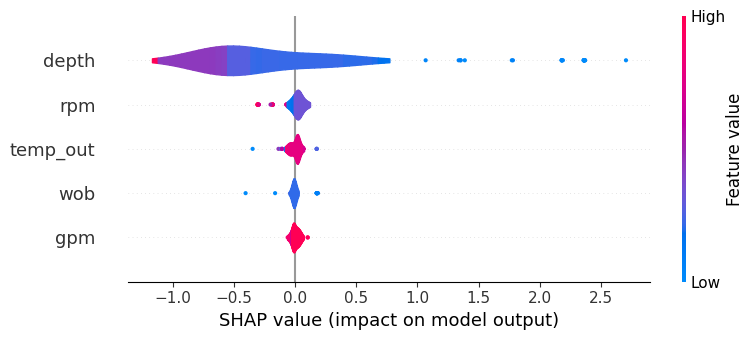

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:08<00:00, 24.60it/s]


Decision Tree Regressor with 50 max terminal nodes


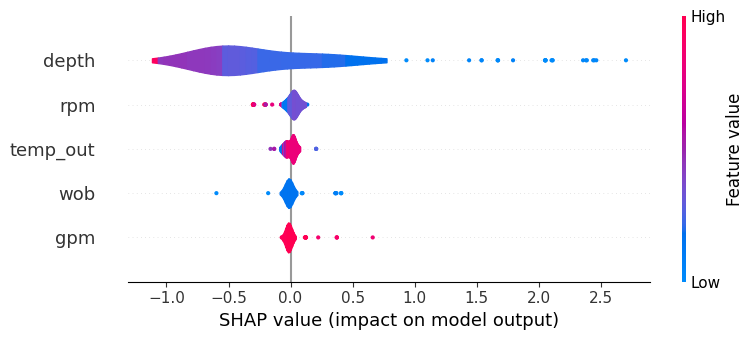

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [00:22<00:00,  8.79it/s]


Random Forest Regressor with 100 trees


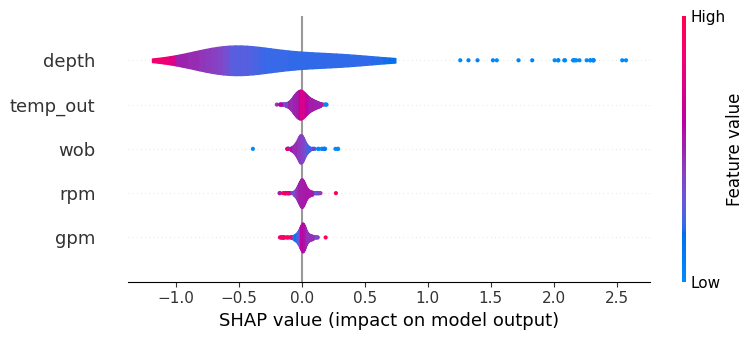

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [01:21<00:00,  2.45it/s]


Random Forest Regressor with 500 trees


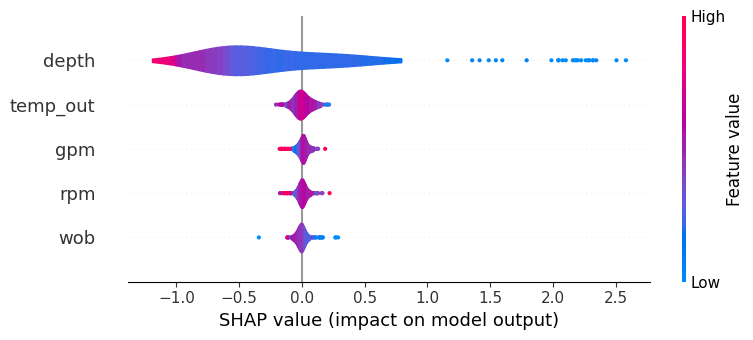

In [145]:
importances = {         #This initializes the sum for importance index of each feature
    'depth':0,
    'wob':0,
    'temp_out':0,
    'rpm':0,
    'gpm':0
}

for model in models:        
    ex = shap.KernelExplainer(models[model].predict, X_subset)
    shap_values = ex.shap_values(X_subset)
    print(model)
    shap.summary_plot(shap_values, X_subset, feature_names=feature_names, plot_type = "violin")
    for index,row in shapley_feature_ranking(shap_values, pd.DataFrame(X_subset, columns=feature_names)).iterrows():
        importances[row['features']] += row['importance'] 

This is very interesting, since we can see how different models disagree on the ranking. There must be however, an underlying true model, but we will now look at the "wisdom of crowd" that emerges from the ensemble. 

Some observations: 

<ul>
<li>Changing the flexibility of the neural network or the activation function, with which its capacity to capture nonlinearity should change, does not influence much in the feature ranking. The same happens with Linear regression and its regularized version (Ridge), or the random forests </li><br>
<li>Conversely, changing the transformation function (kernel) to higher dimension space for SVMs does have a huge impact on feature ranking. This shows that relying on Global Shapley values for feature selection may lead to incorrect recursive elimination or interpretation of feature importance</li><br>
</ul>

### 4. Summary of Ensemble Global Shapley Values

Finally, we summarize the feature ranking by counting the number of times each feature is placed in each position.

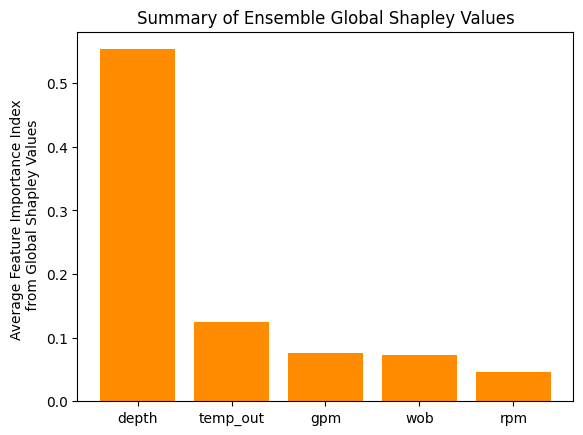

In [167]:
importances_features = [i for i in importances]                 #extracts the keys of the dict
importances_indices = [importances[i]/15 for i in importances]     #extracts the values of the dict and takes the average.
imp_tuples = sorted(zip(importances_indices,importances_features), key=lambda x: x[0], reverse=True) #Sorts by importance index in descending order
importances_indices, importances_features = zip(*imp_tuples)    #reformats the list of zipped tuples to 2 lists again (now ordered)
plt.bar(importances_features, importances_indices, color='darkorange')
plt.ylabel('Average Feature Importance Index \n from Global Shapley Values')
plt.title("Summary of Ensemble Global Shapley Values");              #Plots the importances

### Results

We can see that the ensemble ranking is quite different than many of the models' ranking. From the summary ensemble global Shapley value we see that the feature ranking for the prediction of ROP in the Utah FORGE well 58-32 according to the ensemble is:
<ol>
    <li>Well Depth</li>
    <li>Temperature out</li>
    <li>Flow Rate</li>
    <li>Weight on Bit</li>
    <li>Rotation Speed</li>
</ol>
<br>

Note that for the feature selection problem, this nonuniqueness of the ranking is highly relevant. For instance, if a decision tree regressor with 10 max terminal nodes was assumed instead of the ensemble, an elimination of 1 features implies getting rid of WOB, instead of what the ensemble suggests (RPM).

With this, following Wolpert's non-free lunch theorem suggestion, we demonstrate that to tackle the problem of feature selection by means of Shapley values, we should trust the wisdom of crowd, instead of risking a mmisleading ranking based on a biased model. 

To expand this project, it is recommended to tackle 2 problems: 
1. Computational expense of calculating Shapley values. 
2. Expanding the ensemble and explore the effect of increasing its number of models in the ranking. 

##### An additional note.

The fact that we have an ensemble ranking that leaves WOB as the 2nd least important feature is very interesting and allows us to state some preliminary hypothesis like the following:Utah FORGE field is characterized by very soft rocks, that may be drilled mainly with the impact force of the bit nozzles.


I hope this was helpful,

*Abraham Montes*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
